# Probabilistic Programming for Cosmology with JAX
<a target="_blank" href="https://colab.research.google.com/github/hsimonfroy/talks/blob/main/2024CoPhy/ppl4cosmo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:
# @title Install
# %pip install -q numpyro getdist
# %pip install -q git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples, gaussian_mixtures

from jax import numpy as jnp, random as jr, jit, grad, value_and_grad, hessian, vmap, tree, debug

import numpyro.distributions as dist
from numpyro import sample, deterministic, plate, infer, render_model
from numpyro.handlers import seed, condition, trace
from numpyro.infer.util import log_density

%matplotlib inline
%load_ext autoreload
%autoreload 2

dphppce115.extra.cea.fr
cpu


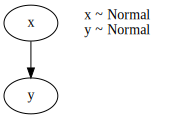

In [4]:
from numpyro import sample, deterministic, plate, render_model

def model():
    x = sample('x', dist.Normal(0, 1))

    ###############
    # TODO: sample y from a Normal distribution with mean x**2 and std 1
    y = sample('y', dist.Normal(x**2, 1))
    ###############

    return y

render_model(model, render_distributions=True)

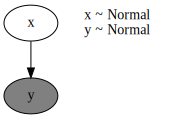

In [5]:
from numpyro.handlers import seed, condition, trace

# Handle random seeds for reproducibility
seeded_model = seed(model, 42)

# Sample from model
y_obs = dict(y=seeded_model())

# Condition model on variable
obs_model = condition(model, y_obs)
render_model(obs_model, render_distributions=True)

In [6]:
class Test():
    def __init__(self, x):
        self.x = x
    
    def __call__(self, y):
        self.x += 1
        return self.x + y
    
test = Test(42)
print(test.x)
res = jit(vmap(test))(jnp.array([1, 2, 3]))
print(res)
print(test.x)

42
[44 45 46]
43


In [19]:
class Test():
    def default(self, x):
        return x
    
    def update_and_call(self, x, n):
        self.default = lambda x: x**n 
        return self.default(x)
    
test = Test()
print(test.default(2))
jfn = jit(vmap(test.update_and_call))
res = jfn(jnp.array([1, 2, 3]), jnp.array([1, 2, 3]))
print(res)
print(test.default(2))   

2
[ 1  4 27]


UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type int32[3] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was update_and_call at /tmp/ipykernel_32835/1847714412.py:5 traced for jit.
------------------------------
The leaked intermediate value was created on line /tmp/ipykernel_32835/1847714412.py:12:6 (<module>). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
<frozen runpy>:198:11 (_run_module_as_main)
<frozen runpy>:88:4 (_run_code)
/tmp/ipykernel_32835/1847714412.py:12:6 (<module>)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [7]:
from dataclasses import dataclass
from numpyro.infer.util import log_density
from numpyro import handlers
from numpyro.infer.reparam import LocScaleReparam
from jax import tree


class Model():
    def _model(self):
        raise NotImplementedError
    
    def model(self):
        return self._model()

    def reset(self):
        self.model = self._model

    def __call__(self):
        return self.model()

    ############
    # Wrappers #
    ############
    def potential(self, params):
        return - log_density(self.model, (), {}, params)[0]
    
    def seed(self, rng=0):
        self.model = handlers.seed(self.model, rng_seed=rng)

    def trace(self, rng=0):
        return handlers.trace(handlers.seed(self.model, rng_seed=rng)).get_trace()
    
    def condition(self, data=None):
        self.model = handlers.condition(self.model, data=data or {})

    def block(self, hide=None, expose=None):
        self.model = handlers.block(self.model, hide=hide, expose=expose)

    def render(self):
        display(render_model(self.model, render_distributions=True, render_params=True))

    ############################

    def reparam(self, params_):
        return params_

    def __str__(self):
        return self.__dict__.__str__()
    
    def block_det(self, model, hide_base=True, hide_det=True):
        base_name = self.latent.keys()
        if hide_base:
            if hide_det:
                hide_fn = lambda site: site['type'] == 'deterministic'
            else:
                hide_fn = lambda site: site['type'] == 'deterministic' and site['name'] in base_name
        else:
            if hide_det:
                hide_fn = lambda site: site['type'] == 'deterministic' and site['name'] not in base_name
            else:
                hide_fn = lambda site: False
        return handlers.block(model, hide_fn=hide_fn)

    def predict(self, rng=0, samples=None, hide_base=True, hide_det=True, hide_samp=False):
        """
        Run model conditionned on samples.
        If samples is None, return a single prediction.
        If samples is an int, return a prediction of that length.
        If samples is a dict, return a prediction for each sample.
        """
        if isinstance(rng, int):
            rng = jr.key(rng)

        def single_prediction(rng, sample={}):
            model = handlers.condition(self.model, data=sample)
            if hide_samp:
                model = handlers.block(model, hide=sample.keys())
            model = self.block_det(model, hide_base=hide_base, hide_det=hide_det)

            tr = handlers.trace(handlers.seed(model, rng_seed=rng)).get_trace()
            return {k: v['value'] for k, v in tr.items()}

        if samples is None:
            return single_prediction(rng)
        if isinstance(samples, int):
            rng = jr.split(rng, samples)
            return vmap(single_prediction)(rng)
        else:
            # All samples should have the same first dimension
            n_samples = samples[next(iter(samples))].shape[0]
            rng = jr.split(rng, n_samples)
            return vmap(single_prediction)(rng, samples)

@dataclass
class MyModel(Model):
    std: float
    latent: dict = None
    mesh_shape: np.ndarray = None
    box_shape: np.ndarray = None

    def __post_init__(self):
        if self.latent is None: 
            self.latent = {}

    def _model(self):
        x = sample('x_', dist.Normal(0, self.std))
        x = deterministic('x', x)

        y_mean = deterministic('y_mean', self.hep(x))
        # y_mean = deterministic('y_mean2', self.hep(y_mean))
        y = sample('y', dist.Normal(y_mean, self.std))
        z = sample('z', dist.Normal(y, self.std))
        return z
    
    def hep(self, x):
        return self.std*x**2
    


model = MyModel(std=1, latent={'x': 0.})
# print(model.potential({'x': 0., 'y': 0.}), model.simulate(42))
model.condition()
model.seed(42)
print(model())
model.reset()
# model.condition({'x_': 0.})
# model.block(hide={'x_': 0.}.keys())
model.predict(0, 1, 1,0,1)
# model.simulate2(42, {'x_': 0.}, 0, 0)
# model.render()
model.seed(42)
model.model()

-0.6223022


Array(-0.6223022, dtype=float32)

In [ ]:
from collections import UserDict
from jax import tree
from pprint import pformat

@dataclass
class Sample(UserDict):
    """
    Global slicing and indexing s[1:3,2]
    Querying with groups s['abc', 'c', 'd'], s[['abc','c'],['d']]
    """
    data: dict
    group: dict

    def __getitem__(self, key):
        # Global indexing and slicing
        if self._istreeof(key, (int, slice)):
            # return self.map(lambda x: x[key])
            return Sample(self.map(lambda x: x[key]), self.group)

        # Querying with groups
        elif self._istreeof(key, str):
            if isinstance(key, str):
                if key in self.group:
                    group = list(self.group[key])
                    if len(group) == 1: # handle length 1 group
                        return self.data[group[0]]
                    else:
                        return tuple(self.data[k] for k in group)
                else:
                    return self.data[key]
                
            elif isinstance(key, list):
                # return {k:self.data[k] for k in self._expand_key(key)}
                return Sample({k:self.data[k] for k in self._expand_key(key)}, self.group)
            
            elif isinstance(key, tuple):
                return tuple(self[k] for k in self._expand_key(key))
    
    def _expand_key(self, key):
        newkey = ()
        for k in key:
            if isinstance(k, str) and k in self.group:
                newkey += tuple(self.group[k])
            else:
                newkey += (k,)
        return newkey
    
    def _istreeof(self, obj, type):
        return tree.all(tree.map(lambda x: isinstance(x, type), obj))
    
    def map(self, fn):
        return tree.map(fn, self.data)
    
    @property
    def shape(self):
        return self.map(np.shape)
    


data = dict(a=1, b=2, c=3, d=4)
data = dict(a=np.ones((2,3)), b=np.ones((2,3)), c=np.ones((3,4)), d=np.ones((4,5)))
group = dict(abc=['a','b','c'], d=['d'])    
s = Sample(data, group)

# print(s[['abc','c'],['d']])
# print(s['abc', 'c', 'd'])
# print(s['abc'])
# print(s[['abc']])
# print(s['d'])
# print(s[['d']])

# print(s[1:,2])
# print(s[1,0])
s[['abc'],['c']]

(Sample(data={'a': array([[1., 1., 1.],
        [1., 1., 1.]]), 'b': array([[1., 1., 1.],
        [1., 1., 1.]]), 'c': array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])}, group={'abc': ['a', 'b', 'c'], 'd': ['d']}),
 Sample(data={'c': array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])}, group={'abc': ['a', 'b', 'c'], 'd': ['d']}))

In [364]:
def _istreeof(obj, type):
    print(tree.leaves(obj))
    return tree.all(tree.map(lambda x: isinstance(x, type), obj))
    # return tree.all(obj, is_leaf=lambda x: not isinstance(x, type))
    # return all(isinstance(i, type) for i in tree.leaves(obj))

_istreeof(('a',['a'], ('a', [slice(1,2)])), (str))

['a', 'a', 'a', slice(1, 2, None)]


False

In [329]:
tree.flatten((2,3,(4,5)))

([2, 3, 4, 5], PyTreeDef((*, *, (*, *))))

In [316]:
np.array([[1,2,3],[4,5,6]])[:,2]

array([3, 6])

In [ ]:
aa = (2,3)
aa = ('c','d')
def istupleof(obj, type):
    return isinstance(obj, tuple) and all(isinstance(i, type) for i in obj)

print(istupleof(aa, int))

True


In [ ]:
class MyClass:
    def method():
        return 'instance method called', 0

    @classmethod
    def classmethod(cls):
        return 'class method called', cls.method()

    @staticmethod
    def staticmethod():
        return 'static method called'
    
obj = MyClass()
# obj.method()
# MyClass.classmethod()
obj.classmethod()

('class method called', ('instance method called', 0))

In [ ]:
from numpyro.infer.util import log_density

# Compute log probability of model
log_joint = lambda params: log_density(model,(),{},params)[0]
print(log_joint({'x': 0., 'y': 0.}))

-1.837877
